In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/salary2025software/2025-yazilim-sektoru-maaslari-onceki-yazilimci.xlsx


Bu çalışmada kullanılan maaş anketi verisi, [Önceki Yazılımcı](https://www.linkedin.com/in/oncekiyazilimci/) adlı geliştirici tarafından oluşturulmuştur.  

İlgili kaynağa aşağıdaki bağlantıdan ulaşılabilir:  
https://github.com/oncekiyazilimci/2025-yazilim-sektoru-maaslari

In [2]:
import re
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_excel("/kaggle/input/salary2025software/2025-yazilim-sektoru-maaslari-onceki-yazilimci.xlsx")

df

,level,position,tech_stack,experience,gender,company,company_size,work_type,city,currency,salary,raise_period
0,Senior,Back-end Developer,"Php, NodeJS, Go",15 Yıl ve üzeri,Erkek,E-Ticaret,101 - 249 Kişi,Remote,* İngiltere,$ - Dolar,8.000 - 8.999,1
1,Senior,Full Stack Developer,"Java, Angular",5 - 7 Yıl,Erkek,Sigorta,250+,Remote,Ankara,₺ - Türk Lirası,140.000 - 144.999,2
2,Senior,Mobile Application Developer (iOS),"Swift, Objective C",10 - 12 Yıl,Erkek,Banka,250+,Remote,Muğla,₺ - Türk Lirası,195.000 - 199.999,2
3,Senior,Mobile Application Developer (iOS),Swift,7 - 10 Yıl,Erkek,E-Ticaret,250+,Ofis,İstanbul,₺ - Türk Lirası,220.000 - 229.999,1
4,Middle,Full Stack Developer,Php,1 - 3 Yıl,Erkek,E-Ticaret,1 - 5 Kişi,Ofis,İstanbul,₺ - Türk Lirası,35.000 - 35.999,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9051,Senior,Team / Tech Lead,".Net, NodeJS, Delphi",15 Yıl ve üzeri,Erkek,ERP & CRM,101 - 249 Kişi,Hibrit (Ofis + Remote),İzmir,₺ - Türk Lirası,175.000 - 179.999,1
9052,Senior,Team / Tech Lead,".Net, Python, Angular",10 - 12 Yıl,Erkek,Yazılım Evi & Danışmanlık,1 - 5 Kişi,Remote,* Birleşik Arap Emirlikleri,₺ - Türk Lirası,170.000 - 174.999,1
9053,Junior,Back-end Developer,Java,0 - 1 Yıl,Erkek,Telekomünikasyon,21 - 50 Kişi,Hibrit (Ofis + Remote),* Azerbaycan,₺ - Türk Lirası,12.000 - 12.999,1
9054,Middle,Front-end Developer,"JavaScript | Html | Css, Vue",1 - 3 Yıl,Erkek,E-Ticaret,101 - 249 Kişi,Hibrit (Ofis + Remote),Kahramanmaraş,₺ - Türk Lirası,64.000 - 64.999,1


In [4]:
print(df.head())

    level                            position          tech_stack  \
0  Senior                  Back-end Developer     Php, NodeJS, Go   
1  Senior                Full Stack Developer       Java, Angular   
2  Senior  Mobile Application Developer (iOS)  Swift, Objective C   
3  Senior  Mobile Application Developer (iOS)               Swift   
4  Middle                Full Stack Developer                 Php   

        experience gender    company    company_size work_type         city  \
0  15 Yıl ve üzeri  Erkek  E-Ticaret  101 - 249 Kişi    Remote  * İngiltere   
1        5 - 7 Yıl  Erkek    Sigorta            250+    Remote       Ankara   
2      10 - 12 Yıl  Erkek      Banka            250+    Remote        Muğla   
3       7 - 10 Yıl  Erkek  E-Ticaret            250+      Ofis     İstanbul   
4        1 - 3 Yıl  Erkek  E-Ticaret      1 - 5 Kişi      Ofis     İstanbul   

          currency             salary  raise_period  
0        $ - Dolar      8.000 - 8.999             1  
1 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9056 entries, 0 to 9055
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   level         9056 non-null   object
 1   position      9056 non-null   object
 2   tech_stack    9052 non-null   object
 3   experience    9056 non-null   object
 4   gender        9056 non-null   object
 5   company       9056 non-null   object
 6   company_size  9056 non-null   object
 7   work_type     9056 non-null   object
 8   city          9056 non-null   object
 9   currency      9056 non-null   object
 10  salary        9056 non-null   object
 11  raise_period  9056 non-null   int64 
dtypes: int64(1), object(11)
memory usage: 849.1+ KB


**SATIR VE SÜTUN KONTROLÜ**

In [6]:
satir, sütun = df.shape
print(f"Satır sayısı(veri sayısı): {satir} \nDeğişken sayısı: {sütun}")

Satır sayısı(veri sayısı): 9056 
Değişken sayısı: 12


In [7]:
df.describe()

,raise_period
count,9056.000000
mean,1.538759
std,0.538767
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,4.000000


**NULL VERİ VE UNIQUE KONTROLÜ**

In [8]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"unique {column} sayaç {len(unique_values)}")
    print(f"uniques {df[column].unique()}")
    print()
    boş_veri = df[column].isnull().sum()

    if boş_veri > 0:
        print(f"Null veri var! Null veri sayısı: {boş_veri}")
    else:
        print("Null veri yoktur!")
    print()
    
    print("****")


unique level sayaç 3
uniques ['Senior' 'Middle' 'Junior']

Null veri yoktur!

****
unique position sayaç 59
uniques ['Back-end Developer' 'Full Stack Developer'
 'Mobile Application Developer (iOS)' 'QA / Manuel Test'
 'Front-end Developer' 'Team / Tech Lead' 'QA / Automation'
 'Data Scientist' 'Director of Software Development' 'Game Developer'
 'Mobile Application Developer (Full Stack & Cross)' 'Data Analyst'
 'Embedded Software Developer' 'Product Owner' 'Software Architect'
 'Mobile Application Developer (Android)' 'Business Analyst'
 'Product Manager' 'DevOps Engineer' 'Consultant'
 'Software Development Manager / Engineering Manager' 'Project Manager'
 'Software Engineer' 'RPA Developer' 'UI/UX Designer' 'AI Engineer'
 'Database Administrator (DBA)' 'Data Engineer' 'Chief Data Officer'
 'IT Manager' 'CTO' 'Robotic Software Engineer' 'R&D Manager'
 'System Engineer' 'Support Engineer' 'Cyber Security' 'Network Engineer'
 'SAP / ABAP Developer & Consultant' 'Business Intelligence'

**TEKRARLAYAN SATIR KONTROLU**

In [9]:
tekrarlayan_kayit=df[df.duplicated()]
print(f"tekrarlayan veri sayısı {tekrarlayan_kayit.shape[0]}")
print(f"tekrarlayan veriler {tekrarlayan_kayit}")

tekrarlayan veri sayısı 30
tekrarlayan veriler        level                                position  \
585   Junior                    Full Stack Developer   
1543  Senior                      Back-end Developer   
2332  Senior                      Back-end Developer   
2422  Middle             Embedded Software Developer   
3219  Middle                        Business Analyst   
3822  Senior                     Front-end Developer   
3823  Senior                     Front-end Developer   
3824  Senior                     Front-end Developer   
3891  Middle                     Front-end Developer   
4154  Middle             Embedded Software Developer   
4456  Senior                      Back-end Developer   
4746  Middle                      Back-end Developer   
5164  Senior                      Software Architect   
5293  Middle                    Full Stack Developer   
5312  Senior                      Back-end Developer   
5801  Middle                    Full Stack Developer   
5

**Veri Ön İşleme**

In [10]:
#Tekrarlayan satırların silinmesi
df.drop_duplicates(inplace=True)

In [11]:
#Satır sayısı kontrol
satir, sütun = df.shape
print(f"Satır sayısı(veri sayısı): {satir} \nDeğişken sayısı: {sütun}")

Satır sayısı(veri sayısı): 9026 
Değişken sayısı: 12


In [12]:
#tech_stack boş verileri doldurma
doldur = "belirtilmemis"
#df['tech_stack'].fillna(doldur,inplace=True)
df.fillna({'tech_stack':doldur},inplace=True)

boş_veri = df['tech_stack'].isnull().sum()
print(f"Tech_stack boş veri kontrolü : {boş_veri}")

Tech_stack boş veri kontrolü : 0


In [13]:
#city sütunundaki baştaki '*' karakterini kaldırma

#def temizle(x):
#    return x.lstrip('* ').strip()
#df['city'] = df['city'].apply(temizle) 

df['city'] = df['city'].apply(lambda x: x.lstrip('* ').strip())

#city sütunu kontrolü

df['city'].unique()

array(['İngiltere', 'Ankara', 'Muğla', 'İstanbul', 'Bursa', 'Samsun',
       'İzmir', 'Antalya', 'Eskişehir', 'Letonya', 'Denizli', 'Almanya',
       'Balıkesir', 'Giresun', 'Mersin', 'Edirne', 'Kocaeli', 'Hatay',
       'Malta', 'Yalova', 'Aydın', 'Ordu', 'Uşak', 'Lüksemburg',
       'Tekirdağ', 'Hong Kong', 'Sakarya', 'Gaziantep', 'Sinop',
       'Hollanda', 'Konya', 'Batman', 'Malatya', 'Kahramanmaraş',
       'Kayseri', 'Türkiye', 'Çanakkale', 'Tokat', 'Artvin', 'Bilecik',
       'ABD', 'Erzurum', 'Afyonkarahisar', 'Düzce', 'Niğde', 'Manisa',
       'Dubai', 'Adana', 'Kanada', 'İsveç', 'Trabzon', 'Ardahan',
       'Diyarbakır', 'Zonguldak', 'Elazığ', 'Sivas', 'İtalya', 'Kilis',
       'Çekya', 'Kastamonu', 'Karabük', 'Yozgat', 'Avusturya', 'Isparta',
       'Kırşehir', 'Osmaniye', 'Bolu', 'Van', 'Estonya', 'Adıyaman',
       'Nevşehir', 'Polonya', 'Erzincan', 'Iğdır', 'KKTC', 'Finlandiya',
       'Avrupa', 'Portekiz', 'Kars', 'Kütahya', 'Amasya',
       'Birleşik Arap Emirlikleri',

In [14]:
#work sütunu Standardize
def standardize_work_type(work):
    work_lower = work.lower()
    if 'remote' in work_lower and 'hibrit' in work_lower:
        return 'Hibrit'
    elif 'remote' in work_lower:
        return 'Remote'
    elif 'hibrit' in work_lower:
        return 'Hibrit'
    elif 'ofis' in work_lower:
        return 'Ofis'
    else:
        return work

In [15]:
df['work_type']=df['work_type'].apply(standardize_work_type)

#work_type sütun kontrol

df['work_type'].value_counts()

work_type
Hibrit    3956
Remote    3590
Ofis      1480
Name: count, dtype: int64

In [16]:
#experience sütunu sayısal hale getirme
def experience_2_numeric(xp):
    xp=str(xp).lower()
    if 'üzeri' in xp or '+' in xp:
        years = int(re.findall(r'\d+', xp)[0])
        return years + 2 # 15 veya biraz üstü -> 15+2 = 17
    elif '-' in xp:
        nums = [int(s) for s in re.findall(r'\d', xp)]
        return sum(nums)/len(nums) if len(nums) > 0 else 0
    elif '0' in xp or 'yeni' in xp: #0-1 Yıl veya benzeri
        return 0.5
    else:
        nums = [int(s) for s in re.findall(r'\d',xp)]
        return nums[0] if len(nums) > 0 else np.nan

df['experience'] = df['experience'].apply(experience_2_numeric)
print(df['experience'].head())


0    17.000000
1     6.000000
2     1.000000
3     2.666667
4     2.000000
Name: experience, dtype: float64


In [17]:
#company_size sütunu sayısal hale getirme

def company_size_2_numeric(size):
    size = str(size).lower()
    if '+' in size:
        num = int(re.findall(r'\d+',size)[0])
        return num + 50 # 250+ -> 250 + 50
    elif '-' in size:
        # 101-249 kişi -> (101+249)/2 = 175
        nums = [int(s) for s in re.findall(r'\d+',size)]
        return sum(nums) / len(nums) if len(nums) > 0 else 0
    else:
        #Tek sayı
        nums = [int(s) for s in re.findall(r'\d+',size)]
        return nums[0] if len(nums) > 0 else np.nan

df['company_size'] = df['company_size'].apply(company_size_2_numeric)

In [18]:
df['salary'].head()

0        8.000 - 8.999
1    140.000 - 144.999
2    195.000 - 199.999
3    220.000 - 229.999
4      35.000 - 35.999
Name: salary, dtype: object

In [19]:
#salary sütunu sayısal hale getirme

def salary_2_numeric(srange):
    srange = str(srange).replace('.', '').replace(',', '') #nokta ve virgül temizliği
    if '+' in srange:
        num = int(re.findall(r'\d+', srange)[0])
        return num + 10000 # 30000+10000
    elif '-' in srange:
        nums = [int(s) for s in re.findall(r'\d+',srange)] 
        return sum(nums) / len(nums) if len(nums) > 0 else 0 # 8000-8999 -> (8000+8999) / 2 = 8499.5
    else:
        #sadece tek bir sayı
        nums = [int(s) for s in re.findall(r'\d+',srange)]
        return nums[0] if len(nums) > 0 else np.nan

df['salary'] = df['salary'].apply(salary_2_numeric)

In [20]:
df['salary'].head()

0      8499.5
1    142499.5
2    197499.5
3    224999.5
4     35499.5
Name: salary, dtype: float64

In [21]:
#maaş kur dönüşümü  -> 28.04.2025 kurlar yuvarlanmıştır

exchange_rates = { 
    '$ - Dolar': 38.0,
    '€ - Euro': 44.0,
    '£ - Sterlin': 52.0,
    '₺ - Türk Lirası': 1.0   
}

In [22]:
def convert_2_try(row):
    currency_symbol = row['currency']
    numeric_salary = row['salary']

    if pd.isna(numeric_salary) or currency_symbol not in exchange_rates:
        return np.nan

    rate = exchange_rates[currency_symbol]
    return numeric_salary * rate

df['salary'] = df.apply(convert_2_try, axis=1)
print(df.head())

print(df['salary'].describe())

    level                            position          tech_stack  experience  \
0  Senior                  Back-end Developer     Php, NodeJS, Go   17.000000   
1  Senior                Full Stack Developer       Java, Angular    6.000000   
2  Senior  Mobile Application Developer (iOS)  Swift, Objective C    1.000000   
3  Senior  Mobile Application Developer (iOS)               Swift    2.666667   
4  Middle                Full Stack Developer                 Php    2.000000   

  gender    company  company_size work_type       city         currency  \
0  Erkek  E-Ticaret         175.0    Remote  İngiltere        $ - Dolar   
1  Erkek    Sigorta         300.0    Remote     Ankara  ₺ - Türk Lirası   
2  Erkek      Banka         300.0    Remote      Muğla  ₺ - Türk Lirası   
3  Erkek  E-Ticaret         300.0      Ofis   İstanbul  ₺ - Türk Lirası   
4  Erkek  E-Ticaret           3.0      Ofis   İstanbul  ₺ - Türk Lirası   

     salary  raise_period  
0  322981.0             1  
1  142

In [23]:
print(df.describe())
#null değer kontrolü
print(f"\n{df.isnull().sum()} ")

        experience  company_size         salary  raise_period
count  9026.000000   9026.000000    9026.000000   9026.000000
mean      4.464399    186.664469  115097.236317      1.538555
std       4.347337    124.371247   64686.917214      0.538911
min       0.500000      3.000000    1499.500000      1.000000
25%       2.000000     35.500000   68499.500000      1.000000
50%       2.666667    300.000000  102499.500000      2.000000
75%       6.000000    300.000000  147499.500000      2.000000
max      17.000000    300.000000  701974.000000      4.000000

level           0
position        0
tech_stack      0
experience      0
gender          0
company         0
company_size    0
work_type       0
city            0
currency        0
salary          0
raise_period    0
dtype: int64 


**Görselleştirme**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


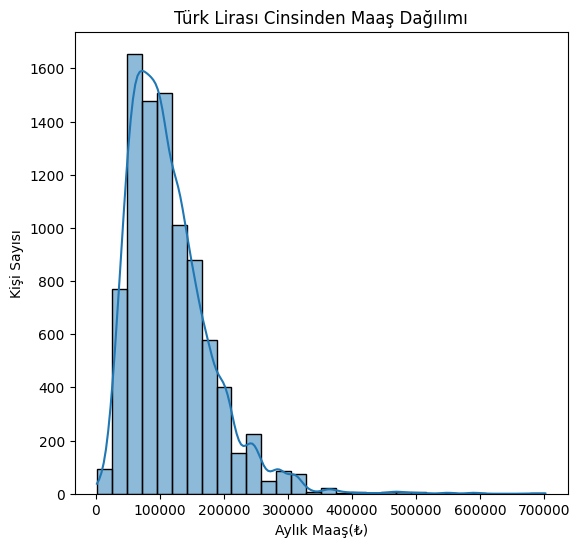

In [24]:
plt.style.use
plt.figure(figsize=(14,6))

#Histogram
plt.subplot(1,2,1)
sns.histplot(df['salary'], kde=True, bins=30)
plt.title('Türk Lirası Cinsinden Maaş Dağılımı')
plt.xlabel('Aylık Maaş(₺)')
plt.ylabel('Kişi Sayısı')

plt.show()

**Tech_stack sütunu çok fazla unique içeriyor**

In [25]:
##tech_stack'i küçük harf + boşlukları temizleme
#df['tech_stack'] = df['tech_stack'].str.lower().str.strip()

##Benzer karakterleri virgülle değiştir
#df['tech_stack'] = df['tech_stack'].str.replace(r"[|/\\]", ",", regex=True)

##Boşlukları temizle
#df['tech_stack'] = df['tech_stack'].str.replace(r"\s+","",regex=True)

#df = df.join(df['tech_stack'].str.get_dummies(sep=',').add_prefix('tech_'))
#df.drop('tech_stack', axis=1, inplace=True)

#değişiklik sonrası sütun kontrolü
print(df.columns)
rows, cols = df.shape
print(f"Satır(Gözlem) Sayısı: {rows} \nSütun(Değişken) Sayısı: {cols}")

Index(['level', 'position', 'tech_stack', 'experience', 'gender', 'company',
       'company_size', 'work_type', 'city', 'currency', 'salary',
       'raise_period'],
      dtype='object')
Satır(Gözlem) Sayısı: 9026 
Sütun(Değişken) Sayısı: 12


In [26]:
#currency ve gender sütunu düşürelim
df.drop(['currency','gender'],axis=1, inplace=True)

**Eğitim/Test ve one-hot encoding**

In [27]:
X = df.drop('salary',axis=1) 
y = df['salary'] # hedef değişken

##one-hot encoding
#X=pd.get_dummies(X, drop_first=True) 

#"One-hot encoding" yaparken, her kategoriyi ayrı sütun yapmak yerine birini atarsak model için hem yeterli olur
# hem de karışıklık yaratmaz.
# Bu iş için drop_first=True kullanırız.

**Label Encoder**

In [28]:
le = LabelEncoder()

#Kategorik Sütunlar
cat_cols=X.select_dtypes(include=['object']).columns

for col in cat_cols:
    X[col]=le.fit_transform(X[col])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model oluşturma**
> XGBoost

In [30]:
#model oluşumu ve eğitim
xgbmodel = XGBRegressor(objective='reg:squarederror',random_state=42)
#xgbmodel.fit(X_train,y_train)

# Parametre grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1]
}

#Grid Search
grid = GridSearchCV(xgbmodel, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1]},
             scoring='r2', verbose=1)

**Tahmin**

In [31]:
best_xgb = grid.best_estimator_
y_pred = best_xgb.predict(X_test)

**Başarı Metrikleri**

In [32]:
mse = mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f} ₺")
print(f"R2 Score: {r2:.2f}")


MAE: 27837.45
MSE: 1772648920.95
RMSE: 42102.84 ₺
R2 Score: 0.57


> One-hot encoding r2 score = **0.55**
> 
> label encoding r2 score = **0.57**

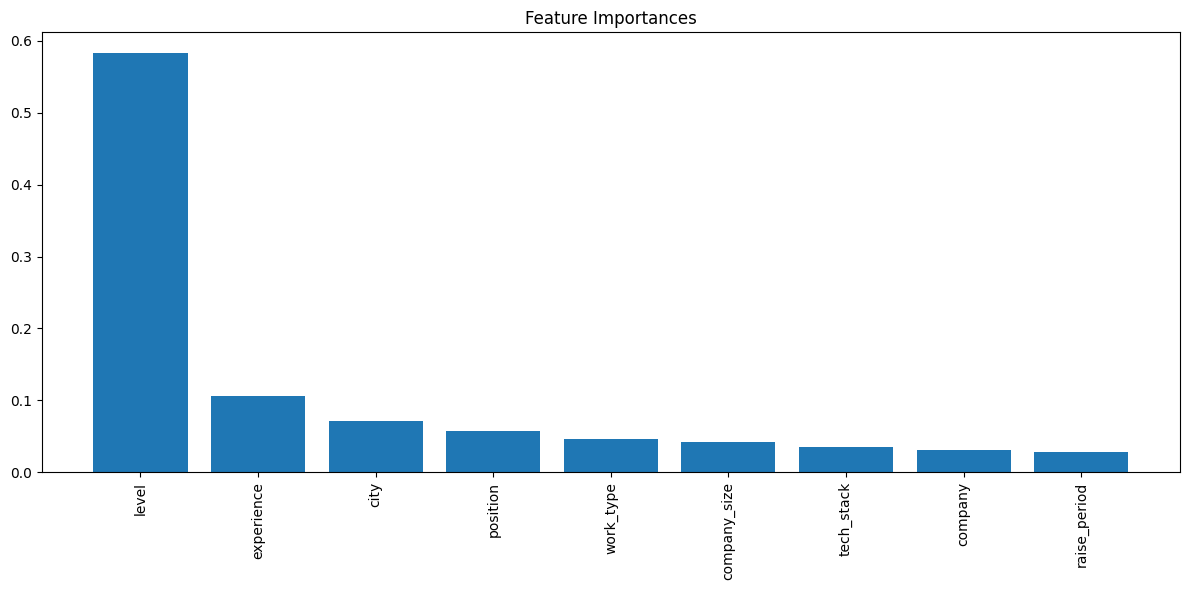

In [33]:
importances = best_xgb.feature_importances_
feature_names = X_train.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()
